In [1]:
'Eigenhouses'

import numpy as np
from numpy import asarray

import os
import imghdr

from PIL import Image, ImageOps

IMAGE_DIR = '/Users/JKMacBook/Documents/Lambda/ImageProject/ImagesProcessed'

def image_process(img_dir):
    i_list = []
    d_list = []
    l_list = []
    
    for root, dirs, files in os.walk(img_dir, topdown=True):
        for name in files:
            fn = os.path.join(root, name)
            image_type = imghdr.what(fn)
            if image_type:
            
                def label(photo_type):
                    switcher={
                              'ba':0,
                              'be':1,
                              'di':2,
                              'ki':3,
                              'li':4,
                              'pr':5,
                              'vi':6,
                              'ya':7
                              }
                    return switcher.get(photo_type,"Invalid file name")
                
                image = Image.open(fn)
                data = asarray(image)
                
                # load images into image_list
                i_list.append(data)
  
                # load images as ravelled array into data_list
                rav_array = np.ravel(data)
                d_list.append(rav_array)

                photo_id = label(name[0:2])
                l_list.append(photo_id)
                
        # convert image_list to numpy array
        i_list = np.array(i_list)

        # convert data_list to numpy array
        d_list = np.array(d_list)

        # convert label_list to numpy array
        l_list = np.array(l_list)
        
        return i_list, d_list, l_list

image_list, data_list, label_list = image_process(IMAGE_DIR)

print(image_list.shape)
print(data_list.shape)
print(label_list.shape)


(411, 160, 240)
(411, 38400)
(411,)


In [2]:
# imports
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [3]:
# load the data
n_samples, h, w = image_list.shape

X = data_list
n_features = X.shape[1]

y = label_list
name_list = ['Bath', 'Bed', 'Dining', 'Kitchen', 'Living', 'Profile', 'View', 'Yard']
target_names = np.array(name_list)
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 411
n_features: 38400
n_classes: 8


In [4]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [6]:
n_components = 300

print("Extracting the top %d eigenhouses from %d houses"
      % (n_components, X_train.shape[0]))

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenhouses = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenhouses orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 300 eigenhouses from 308 houses
Projecting the input data on the eigenhouses orthonormal basis


In [7]:
print("Fitting the classifier to the training set")

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [8]:
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

              precision    recall  f1-score   support

        Bath       0.20      1.00      0.33        18
         Bed       0.62      0.26      0.37        19
      Dining       0.00      0.00      0.00        10
     Kitchen       0.00      0.00      0.00        11
      Living       0.50      0.07      0.12        15
     Profile       0.00      0.00      0.00        17
        View       0.00      0.00      0.00         9
        Yard       0.00      0.00      0.00         4

    accuracy                           0.23       103
   macro avg       0.17      0.17      0.10       103
weighted avg       0.22      0.23      0.14       103

[[18  0  0  0  0  0  0  0]
 [14  5  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0]
 [10  1  0  0  0  0  0  0]
 [13  1  0  0  1  0  0  0]
 [13  1  0  1  1  0  0  1]
 [ 8  0  0  0  0  1  0  0]
 [ 4  0  0  0  0  0  0  0]]


/Users/JKMacBook/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

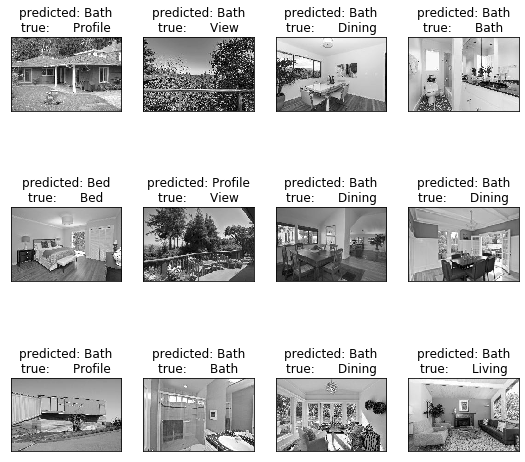

In [10]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)